# Imports

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import gensim.downloader as api

# Data Loading

In [467]:
## Load cleaned data
X_reviews = pd.read_csv("/Users/egmac/code/arostagnat/BookMatch/data/proc_data/X_proc_full_jsonlines.csv")

In [468]:
## Load metadata
metadata_movies = pd.read_json("/Users/egmac/code/arostagnat/BookMatch/data/raw_data/raw_movies/metadata.json", lines=True)
metadata_books = pd.read_json("/Users/egmac/code/arostagnat/BookMatch/data/raw_data/raw_book/metadata.json", lines=True)

In [469]:
# Adjust metadata columns to match X_reviews
metadata_movies.rename({"item_id":"item_id_movie", "title":"title_movie"}, axis='columns',inplace=True)
metadata_books.rename({"item_id":"item_id_book", "title":"title_book","img":"img_book","url":"url_book"}, axis='columns',inplace=True)

In [470]:
## Adjust import to replace $$$ with 0, and convert item_id to float to enable merge. 
## Note that the X_reviews import is preformatted as a float
X_reviews = X_reviews.replace({'$$$': 0}, regex=False)
X_reviews.item_id_movie = X_reviews.item_id_movie.astype(float)
X_reviews.item_id_book = X_reviews.item_id_book.astype(float)

In [471]:
## Revise metadata item_id to float to match X_reviews
metadata_movies.item_id_movie = metadata_movies.item_id_movie.astype(float)
metadata_books.item_id_book = metadata_books.item_id_book.astype(float)

In [472]:
## Merge X_reviews and metadata
X_all = pd.merge(X_reviews, metadata_movies[["title_movie","item_id_movie"]], on="item_id_movie", how="left")
X_all = pd.merge(X_all, metadata_books[["title_book","item_id_book","url_book","img_book"]], on="item_id_book", how="left")

In [473]:
## Check import
X_all.head(1)

,item_id_movie,txt,is_movie,item_id_book,title_movie,title_book,url_book,img_book
0,1.0,one film start clich remember well six year ol...,1,0.0,Toy Story (1995),NaN,NaN,NaN


# Bert embedding


In [4]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, Birch, BisectingKMeans
from sentence_transformers import SentenceTransformer # Make sure you have done a "pip install -e ." to have SentenceTransformer package installed

In [474]:
## Initiate bert embedding
bert = SentenceTransformer('all-MiniLM-L6-v2')

In [475]:
bert_embeddings = bert.encode(X_all["txt"])
np.shape(bert_embeddings)

(61455, 384)

# Agglomerative clustering

In [ ]:
## Initiate clustering
# N_CLUSTER = 1_000
# clustering_bert = AgglomerativeClustering(n_clusters=N_CLUSTER).fit(bert_embeddings)

In [ ]:
## Add clustering and vectors to X_all
# X_all["cluster_bert"] = clustering_bert.labels_
X_all["vector"] = bert_embeddings.tolist()

In [205]:
X_all.head(3)

,item_id_movie,txt,is_movie,item_id_book,title_movie,title_book,url_book,img_book,cluster_bert,vector
0,1.0,one film start clich remember well six year ol...,1,0.0,Toy Story (1995),NaN,NaN,NaN,240,"[-0.08743363618850708, -0.10916568338871002, 0..."
1,2.0,fun little movie hide back drawer movie play c...,1,0.0,Jumanji (1995),NaN,NaN,NaN,352,"[-0.03691134229302406, -0.09489640593528748, -..."
2,4.0,extra movie actually extra movie quite fun tim...,1,0.0,Waiting to Exhale (1995),NaN,NaN,NaN,40,"[-0.051957421004772186, -0.12929892539978027, ..."


# Recommendation

In [163]:
## Import relevant packages

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [169]:
## Create extract of X_all with vectors spread across columns, and confirm relevance of dimensions

X_vectors = X_all.vector.tolist()
X_vectors = pd.DataFrame(X_vectors)

svd = TruncatedSVD(n_components=X_vectors.shape[1])
latent_df = svd.fit_transform(X_vectors)

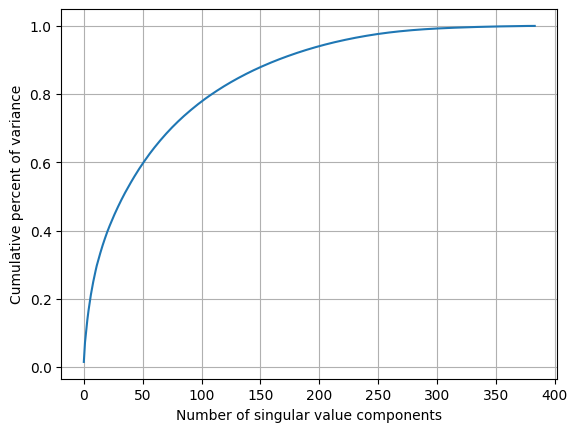

In [171]:
## Plot variance as a function of the number of components.
## Based on the below figure, nearly 100% of the variance is explained by 250 components
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('Number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [190]:
## Reshape vectors to 250 components, which will help reduce computational time
n = 250
X_vectors_revised = pd.DataFrame(X_vectors.iloc[:,0:n])
print(f'X_all shape: {X_all.shape} | X_vectors shape: {X_vectors.shape} | X_vectors shape: {X_vectors_revised.shape}')

X_all shape: (16123, 10) | X_vectors shape: (16123, 384) | X_vectors shape: (16123, 250)


In [206]:
## Add qualitative columns to X_vectors_revised, and then create 2 separate dataframes for books and movies.
## Movie dataframe to be used to lookup user-inputted movies. Book dataframe to be used for calculations.
## Note that the dataframes need to be separated eventually, so it's worth doing now.

X_vectors_revised[["item_id_movie","item_id_book","is_movie"]] = X_all[["item_id_movie","item_id_book","is_movie"]]

X_vectors_books = X_vectors_revised[X_vectors_revised.is_movie == 0].set_index("item_id_book",drop=True).drop(columns=["item_id_movie","is_movie"])
X_vectors_movies = X_vectors_revised[X_vectors_revised.is_movie == 1].set_index("item_id_movie",drop=True).drop(columns=["item_id_book","is_movie"])

In [255]:
## Input sample data
user_movies = [5816,40815,54001,69844]
## [5816,40815,54001,69844]

In [459]:
## Method 1: For each film in user list, calculate the cosine similarity with all books in the cluster
## Then, sort the books by their cosine similarity to identify **the** **closest** book for each film
## Finally, take the full list of book recommendations and then identify the **top 5 most frequent** books

def get_local_reccs(user_movies:list):
    
    verified_movies = [movie_id for movie_id in user_movies if movie_id in X_all.item_id_movie.tolist()]
    
    recommendations = pd.DataFrame(columns=["similarity","title_book","img_book","url_book"])
    movies = pd.DataFrame(verified_movies,columns=["item_id_movie"])
    movies = pd.merge(movies,X_all[["title_movie","item_id_movie"]],on="item_id_movie",how="left")
    
    for movie_id in verified_movies:

        # Obtain vectors for user-inputted film and all books. Clusters are not used for time being
        ### movie_cluster = X_vectors_movies[X_vectors_movies.index == movie_id].cluster_bert.values[0]
        movie_vector = X_vectors_movies[X_vectors_movies.index == movie_id]
        books_vectors = X_vectors_books

        # Calculate cosine similarity
        sim_books = cosine_similarity(books_vectors,movie_vector)
 
        # Create summary table of books with their similarity and relevant details
        sim_books_detail = pd.DataFrame(sim_books,index=books_vectors.index,columns=["similarity"])
        sim_books_detail = sim_books_detail.sort_values("similarity",ascending=False)
        sim_books_detail = pd.merge(sim_books_detail,X_all[["title_book","img_book","url_book","item_id_book"]],
                                    on="item_id_book",how="left")

        # Add top book to recommendations dataframe
        top_book = pd.DataFrame([sim_books_detail.loc[0]])
        recommendations = pd.concat([recommendations,top_book],axis=0, ignore_index=True)
    
    print("Inputted films")
    print(movies)
    return recommendations["title_book"]


In [440]:
## Method 2: Calculate the average vector for all films in the user list, and then identify the corresponding cluster
## Then,calculate the cosine similarity with all books in the cluster
## Finally, sort the books by their cosine similarities and take the **top 5 closest** books

def get_global_reccs(user_movies:list):
    
    verified_movies = [movie_id for movie_id in user_movies if movie_id in X_all.item_id_movie.tolist()]
    
    ## Collect vectors of all inputted films and calculate average vector
    movies_id = pd.DataFrame(verified_movies,columns=["item_id_movie"])
    movies_vectors = pd.merge(movies_id,
                              X_vectors_movies,
                              how="left",
                              on="item_id_movie").set_index("item_id_movie")
    avg_movie_vector = pd.DataFrame([movies_vectors.mean()])
    books_vectors = X_vectors_books

    ## Calculate cosine similarity
    sim_books = cosine_similarity(books_vectors,movie_vector)

    ## Create summary table of books with their similarity and relevant details
    sim_books_detail = pd.DataFrame(sim_books,index=books_vectors.index,columns=["similarity"])
    sim_books_detail = sim_books_detail.sort_values("similarity",ascending=False)
    sim_books_detail = pd.merge(sim_books_detail,X_all[["title_book","img_book","url_book","item_id_book"]],on="item_id_book",how="left")
    
    ## Take top 5 books and show results
    recommendations = sim_books_detail.head(5)
    movie_titles = pd.merge(movies_id,X_all[["title_movie","item_id_movie"]],how="inner",on="item_id_movie")
    print("Inputted films")
    print(movie_titles.title_movie)
    print ("Top 5 book recommendations")
    return recommendations["title_book"]

In [454]:
top_book = pd.DataFrame([sim_books_detail.loc[0]])
top_book

,item_id_book,similarity,title_book,img_book,url_book
0,387.0,0.628951,The Game: Penetrating the Secret Society of Pi...,https://images.gr-assets.com/books/1410129471m...,https://www.goodreads.com/book/show/900.The_Game


In [460]:
get_local_reccs([1,2,3,4,5,6,7])

Inputted films
   item_id_movie                         title_movie
0              1                    Toy Story (1995)
1              2                      Jumanji (1995)
2              4            Waiting to Exhale (1995)
3              5  Father of the Bride Part II (1995)
4              6                         Heat (1995)
5              7                      Sabrina (1995)


0                           Hatchet (Brian's Saga, #1)
1                                The Phantom Tollbooth
2    The Game: Penetrating the Secret Society of Pi...
3    The Game: Penetrating the Secret Society of Pi...
4                                           The Broker
5    Fullmetal Alchemist, Vol. 1 (Fullmetal Alchemi...
Name: title_book, dtype: object

In [412]:
get_global_reccs([1,2,3,4,5,6,7])

Inputted films
0                      Toy Story (1995)
1                        Jumanji (1995)
2              Waiting to Exhale (1995)
3    Father of the Bride Part II (1995)
4                           Heat (1995)
5                        Sabrina (1995)
Name: title_movie, dtype: object
Top 5 book recommendations


0    The Game: Penetrating the Secret Society of Pi...
1              Men Are from Mars, Women Are from Venus
2    The Hitchhiker's Guide to the Galaxy (Hitchhik...
3                          Slouching Towards Bethlehem
4                                        Anna Karenina
Name: title_book, dtype: object